 ## Preprocessing

In [1]:
# Install required packages.
import os
import torch
import numpy as np
from scipy import stats
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

D:\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


1.13.1+cpu


In [2]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [3]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


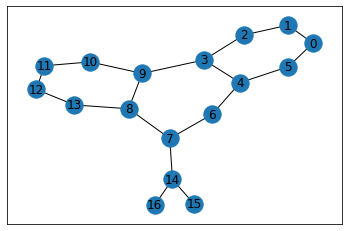

In [4]:
import networkx as nx
import torch_geometric
g = torch_geometric.utils.to_networkx(train_dataset[0], to_undirected=True)
nx.draw_networkx(g)

In [9]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2560], x=[1154, 7], edge_attr=[2560, 4], y=[64], batch=[1154], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2454], x=[1121, 7], edge_attr=[2454, 4], y=[64], batch=[1121], ptr=[65])

Step 3:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 980], x=[439, 7], edge_attr=[980, 4], y=[22], batch=[439], ptr=[23])



## Defining functions

In [16]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GatedGraphConv
from torch_geometric.nn import global_mean_pool, global_max_pool, SAGPooling


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, Conv_method , Pool_method):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = Conv_method(dataset.num_node_features, hidden_channels)
        self.conv2 = Conv_method(hidden_channels, hidden_channels)
        self.conv3 = Conv_method(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)
        self.pool = Pool_method

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = self.pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x
    
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

## Standard convolution, standard global mean

In [17]:
model = GCN(Conv_method=GCNConv, Pool_method=global_mean_pool,  hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

nb_epoch = 201
List_last_accuracy_train = []
List_last_accuracy_test = []

for epoch in range(1, nb_epoch):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    if epoch >= 0.9*nb_epoch:
        List_last_accuracy_train.append(train_acc)
        List_last_accuracy_test.append(test_acc)
    if epoch % 20 ==0:
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        
CI_train = stats.norm.interval(0.95, loc=np.array(List_last_accuracy_train).mean(), 
                               scale=np.array(List_last_accuracy_train).std()/np.sqrt(len(List_last_accuracy_train)))
CI_test = stats.norm.interval(0.95, loc=np.array(List_last_accuracy_test).mean(), 
                              scale=np.array(List_last_accuracy_test).std()/np.sqrt(len(List_last_accuracy_test)))

print("\n")
print("CI_train : [" + str(round(CI_train[0],3)) + "," +  str(round(CI_train[1],3)) + "]")
print("CI_test : [" + str(round(CI_test[0],3)) + "," +  str(round(CI_test[1],3)) + "]")

Epoch: 020, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 040, Train Acc: 0.6800, Test Acc: 0.7632
Epoch: 060, Train Acc: 0.7133, Test Acc: 0.7895
Epoch: 080, Train Acc: 0.7667, Test Acc: 0.7895
Epoch: 100, Train Acc: 0.7667, Test Acc: 0.7895
Epoch: 120, Train Acc: 0.7733, Test Acc: 0.8421
Epoch: 140, Train Acc: 0.7667, Test Acc: 0.7632
Epoch: 160, Train Acc: 0.7733, Test Acc: 0.8158
Epoch: 180, Train Acc: 0.7800, Test Acc: 0.7895
Epoch: 200, Train Acc: 0.7733, Test Acc: 0.7632


CI_train : [0.773,0.777]
CI_test : [0.779,0.795]


## GAT convolution, standard global mean

In [19]:
model = GCN(Conv_method=GATConv, Pool_method=global_mean_pool, hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

List_last_accuracy_train = []
List_last_accuracy_test = []

for epoch in range(1, nb_epoch):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    if epoch >= 0.9*nb_epoch:
        List_last_accuracy_train.append(train_acc)
        List_last_accuracy_test.append(test_acc)
    if epoch % 10 ==0:
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        
CI_train = stats.norm.interval(0.95, loc=np.array(List_last_accuracy_train).mean(), 
                               scale=np.array(List_last_accuracy_train).std()/np.sqrt(len(List_last_accuracy_train)))
CI_test = stats.norm.interval(0.95, loc=np.array(List_last_accuracy_test).mean(), 
                              scale=np.array(List_last_accuracy_test).std()/np.sqrt(len(List_last_accuracy_test)))

print("\n")
print("CI_train : [" + str(round(CI_train[0],3)) + "," +  str(round(CI_train[1],3)) + "]")
print("CI_test : [" + str(round(CI_test[0],3)) + "," +  str(round(CI_test[1],3)) + "]")

Epoch: 010, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 020, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 030, Train Acc: 0.7400, Test Acc: 0.7632
Epoch: 040, Train Acc: 0.7467, Test Acc: 0.7895
Epoch: 050, Train Acc: 0.7467, Test Acc: 0.7895
Epoch: 060, Train Acc: 0.7667, Test Acc: 0.7895
Epoch: 070, Train Acc: 0.7733, Test Acc: 0.7895
Epoch: 080, Train Acc: 0.7733, Test Acc: 0.8421
Epoch: 090, Train Acc: 0.7733, Test Acc: 0.8421
Epoch: 100, Train Acc: 0.7733, Test Acc: 0.8158
Epoch: 110, Train Acc: 0.7800, Test Acc: 0.8158
Epoch: 120, Train Acc: 0.7733, Test Acc: 0.7895
Epoch: 130, Train Acc: 0.7800, Test Acc: 0.7632
Epoch: 140, Train Acc: 0.7933, Test Acc: 0.8421
Epoch: 150, Train Acc: 0.7867, Test Acc: 0.8421
Epoch: 160, Train Acc: 0.7933, Test Acc: 0.7895
Epoch: 170, Train Acc: 0.8000, Test Acc: 0.8421
Epoch: 180, Train Acc: 0.8000, Test Acc: 0.7632
Epoch: 190, Train Acc: 0.8067, Test Acc: 0.7895
Epoch: 200, Train Acc: 0.8200, Test Acc: 0.7632


CI_train : [0.807,0.811]
CI_test : [0.

## GatedGraphConv convolution, standard global mean

In [23]:
model = GCN(Conv_method=GatedGraphConv, Pool_method=global_mean_pool, hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

List_last_accuracy_train = []
List_last_accuracy_test = []

for epoch in range(1, nb_epoch):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    if epoch >= 0.9*nb_epoch:
        List_last_accuracy_train.append(train_acc)
        List_last_accuracy_test.append(test_acc)
    if epoch % 10 ==0:
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        
CI_train = stats.norm.interval(0.95, loc=np.array(List_last_accuracy_train).mean(), 
                               scale=np.array(List_last_accuracy_train).std()/np.sqrt(len(List_last_accuracy_train)))
CI_test = stats.norm.interval(0.95, loc=np.array(List_last_accuracy_test).mean(), 
                              scale=np.array(List_last_accuracy_test).std()/np.sqrt(len(List_last_accuracy_test)))

print("\n")
print("CI_train : [" + str(round(CI_train[0],3)) + "," +  str(round(CI_train[1],3)) + "]")
print("CI_test : [" + str(round(CI_test[0],3)) + "," +  str(round(CI_test[1],3)) + "]")

Epoch: 010, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 020, Train Acc: 0.6133, Test Acc: 0.5263
Epoch: 030, Train Acc: 0.8400, Test Acc: 0.8158
Epoch: 040, Train Acc: 0.8333, Test Acc: 0.8158
Epoch: 050, Train Acc: 0.8600, Test Acc: 0.8158
Epoch: 060, Train Acc: 0.8400, Test Acc: 0.7895
Epoch: 070, Train Acc: 0.7867, Test Acc: 0.7632
Epoch: 080, Train Acc: 0.8533, Test Acc: 0.8158
Epoch: 090, Train Acc: 0.8333, Test Acc: 0.8158
Epoch: 100, Train Acc: 0.8200, Test Acc: 0.7632
Epoch: 110, Train Acc: 0.8333, Test Acc: 0.8158
Epoch: 120, Train Acc: 0.7133, Test Acc: 0.6053
Epoch: 130, Train Acc: 0.8467, Test Acc: 0.7895
Epoch: 140, Train Acc: 0.8667, Test Acc: 0.8158
Epoch: 150, Train Acc: 0.8467, Test Acc: 0.8158
Epoch: 160, Train Acc: 0.8400, Test Acc: 0.8158
Epoch: 170, Train Acc: 0.7400, Test Acc: 0.7632
Epoch: 180, Train Acc: 0.8333, Test Acc: 0.8158
Epoch: 190, Train Acc: 0.8133, Test Acc: 0.7632
Epoch: 200, Train Acc: 0.8667, Test Acc: 0.8158


CI_train : [0.826,0.848]
CI_test : [0.

## Standard convolution, max pooling

In [20]:
model = GCN(Conv_method=GCNConv, Pool_method=global_max_pool,  hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

List_last_accuracy_train = []
List_last_accuracy_test = []

for epoch in range(1, nb_epoch):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    if epoch >= 0.9*nb_epoch:
        List_last_accuracy_train.append(train_acc)
        List_last_accuracy_test.append(test_acc)
    if epoch % 20 ==0:
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        
CI_train = stats.norm.interval(0.95, loc=np.array(List_last_accuracy_train).mean(), 
                               scale=np.array(List_last_accuracy_train).std()/np.sqrt(len(List_last_accuracy_train)))
CI_test = stats.norm.interval(0.95, loc=np.array(List_last_accuracy_test).mean(), 
                              scale=np.array(List_last_accuracy_test).std()/np.sqrt(len(List_last_accuracy_test)))

print("\n")
print("CI_train : [" + str(round(CI_train[0],3)) + "," +  str(round(CI_train[1],3)) + "]")
print("CI_test : [" + str(round(CI_test[0],3)) + "," +  str(round(CI_test[1],3)) + "]")

Epoch: 020, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 040, Train Acc: 0.7800, Test Acc: 0.7368
Epoch: 060, Train Acc: 0.7867, Test Acc: 0.7368
Epoch: 080, Train Acc: 0.7933, Test Acc: 0.7632
Epoch: 100, Train Acc: 0.8000, Test Acc: 0.7105
Epoch: 120, Train Acc: 0.7933, Test Acc: 0.7105
Epoch: 140, Train Acc: 0.7867, Test Acc: 0.7632
Epoch: 160, Train Acc: 0.7867, Test Acc: 0.7368
Epoch: 180, Train Acc: 0.8000, Test Acc: 0.7632
Epoch: 200, Train Acc: 0.8067, Test Acc: 0.7105


CI_train : [0.788,0.798]
CI_test : [0.712,0.727]


## GAT convolution, max pooling

In [21]:
model = GCN(Conv_method=GATConv, Pool_method=global_max_pool, hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

List_last_accuracy_train = []
List_last_accuracy_test = []

for epoch in range(1, nb_epoch):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    if epoch >= 0.9*nb_epoch:
        List_last_accuracy_train.append(train_acc)
        List_last_accuracy_test.append(test_acc)
    if epoch % 10 ==0:
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        
CI_train = stats.norm.interval(0.95, loc=np.array(List_last_accuracy_train).mean(), 
                               scale=np.array(List_last_accuracy_train).std()/np.sqrt(len(List_last_accuracy_train)))
CI_test = stats.norm.interval(0.95, loc=np.array(List_last_accuracy_test).mean(), 
                              scale=np.array(List_last_accuracy_test).std()/np.sqrt(len(List_last_accuracy_test)))

print("\n")
print("CI_train : [" + str(round(CI_train[0],3)) + "," +  str(round(CI_train[1],3)) + "]")
print("CI_test : [" + str(round(CI_test[0],3)) + "," +  str(round(CI_test[1],3)) + "]")

Epoch: 010, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 020, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 030, Train Acc: 0.7267, Test Acc: 0.7895
Epoch: 040, Train Acc: 0.7733, Test Acc: 0.7632
Epoch: 050, Train Acc: 0.7867, Test Acc: 0.7632
Epoch: 060, Train Acc: 0.8067, Test Acc: 0.7368
Epoch: 070, Train Acc: 0.8000, Test Acc: 0.7632
Epoch: 080, Train Acc: 0.8067, Test Acc: 0.7632
Epoch: 090, Train Acc: 0.8200, Test Acc: 0.7368
Epoch: 100, Train Acc: 0.8067, Test Acc: 0.7368
Epoch: 110, Train Acc: 0.7933, Test Acc: 0.7368
Epoch: 120, Train Acc: 0.8200, Test Acc: 0.7105
Epoch: 130, Train Acc: 0.8067, Test Acc: 0.7368
Epoch: 140, Train Acc: 0.8067, Test Acc: 0.7895
Epoch: 150, Train Acc: 0.8133, Test Acc: 0.7368
Epoch: 160, Train Acc: 0.8133, Test Acc: 0.7368
Epoch: 170, Train Acc: 0.8067, Test Acc: 0.7368
Epoch: 180, Train Acc: 0.8067, Test Acc: 0.7368
Epoch: 190, Train Acc: 0.8133, Test Acc: 0.7368
Epoch: 200, Train Acc: 0.8067, Test Acc: 0.7368


CI_train : [0.809,0.813]
CI_test : [0.

## GatedGraphConv convolution, max pooling

In [24]:
model = GCN(Conv_method=GatedGraphConv, Pool_method=global_max_pool, hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

List_last_accuracy_train = []
List_last_accuracy_test = []

for epoch in range(1, nb_epoch):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    if epoch >= 0.9*nb_epoch:
        List_last_accuracy_train.append(train_acc)
        List_last_accuracy_test.append(test_acc)
    if epoch % 10 ==0:
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        
CI_train = stats.norm.interval(0.95, loc=np.array(List_last_accuracy_train).mean(), 
                               scale=np.array(List_last_accuracy_train).std()/np.sqrt(len(List_last_accuracy_train)))
CI_test = stats.norm.interval(0.95, loc=np.array(List_last_accuracy_test).mean(), 
                              scale=np.array(List_last_accuracy_test).std()/np.sqrt(len(List_last_accuracy_test)))

print("\n")
print("CI_train : [" + str(round(CI_train[0],3)) + "," +  str(round(CI_train[1],3)) + "]")
print("CI_test : [" + str(round(CI_test[0],3)) + "," +  str(round(CI_test[1],3)) + "]")

Epoch: 010, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 020, Train Acc: 0.8667, Test Acc: 0.8158
Epoch: 030, Train Acc: 0.8667, Test Acc: 0.8158
Epoch: 040, Train Acc: 0.8667, Test Acc: 0.8158
Epoch: 050, Train Acc: 0.8067, Test Acc: 0.7632
Epoch: 060, Train Acc: 0.8467, Test Acc: 0.8158
Epoch: 070, Train Acc: 0.8000, Test Acc: 0.7632
Epoch: 080, Train Acc: 0.8267, Test Acc: 0.8158
Epoch: 090, Train Acc: 0.8400, Test Acc: 0.8158
Epoch: 100, Train Acc: 0.8333, Test Acc: 0.8158
Epoch: 110, Train Acc: 0.8733, Test Acc: 0.8158
Epoch: 120, Train Acc: 0.6867, Test Acc: 0.5789
Epoch: 130, Train Acc: 0.8533, Test Acc: 0.8158
Epoch: 140, Train Acc: 0.8600, Test Acc: 0.7895
Epoch: 150, Train Acc: 0.8600, Test Acc: 0.8158
Epoch: 160, Train Acc: 0.8667, Test Acc: 0.8158
Epoch: 170, Train Acc: 0.8467, Test Acc: 0.8158
Epoch: 180, Train Acc: 0.8400, Test Acc: 0.8158
Epoch: 190, Train Acc: 0.8400, Test Acc: 0.8158
Epoch: 200, Train Acc: 0.8733, Test Acc: 0.8158


CI_train : [0.842,0.862]
CI_test : [0.